In [1]:
from __future__ import annotations
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from makemore import MLP, load_words

%matplotlib inline

In [2]:
words: list[str] = open("names.txt", "r").read().splitlines()

In [3]:
# Gets all the characters, a-z
chars: list[str] = sorted(list(set("".join(words))))

# Maps each character to an integer
stoi: dict[str, int] = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0

# Maps each integer to a character
itos: dict[int, str] = {i: s for s, i in stoi.items()}

In [4]:
block_size = 3  # Context length: number of characters taken to predict the next one


# Build dataset
def build_dataset(
    words: list[str], print_examples: int = 0
) -> tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []
    for i, w in enumerate(words):
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if i < print_examples:
                print("".join(itos[i] for i in context), "---->", itos[ix])
            context = context[1:] + [ix]

    return torch.tensor(X), torch.tensor(Y)

In [5]:
X, Y = build_dataset(words, 5)

... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
... ----> a
..a ----> v
.av ----> a
ava ----> .
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [6]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

## MLP (Multilayer Perceptron)

![mlp](https://miro.medium.com/v2/resize:fit:1200/1*EqKiy4-6tuLSoPP_kub33Q.png)


In [7]:
# Embedding lookup table
C = torch.randn((27, 2))

In [8]:
# Parameters
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [9]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [10]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)  # Number of parameters in total

3481

In [11]:
# Forward pass
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [12]:
emb.view(-1, 6).shape

torch.Size([228146, 6])

In [13]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
print(h)
h.shape

tensor([[-0.8603,  0.7583,  0.9819,  ...,  0.1263,  0.9425,  0.3149],
        [-0.5587,  0.0816,  0.5462,  ..., -0.6786,  0.9888,  0.3046],
        [-0.3584, -0.4610,  0.7782,  ...,  0.9893,  0.9776, -0.4091],
        ...,
        [-0.6235,  0.9096,  0.8989,  ..., -0.9999,  0.9999, -0.3957],
        [-0.7399,  0.9951,  0.9997,  ...,  0.9999,  0.9994, -0.9841],
        [-0.9978, -0.9998, -0.9424,  ...,  0.3046, -0.9844,  0.9994]])


torch.Size([228146, 100])

In [14]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [15]:
counts = logits.exp()
prob = counts / counts.sum(-1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [16]:
loss = -prob[torch.arange(len(Y)), Y].log().mean()
loss

tensor(18.9086)

In [17]:
loss = F.cross_entropy(logits, Y)
loss

tensor(18.9086)

In [18]:
for p in parameters:
    p.requires_grad = True

In [19]:
# Learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [20]:
# Find optimal learning rate
lri = []
lossi = []

for i in range(1000):
    # Minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

9.649470329284668


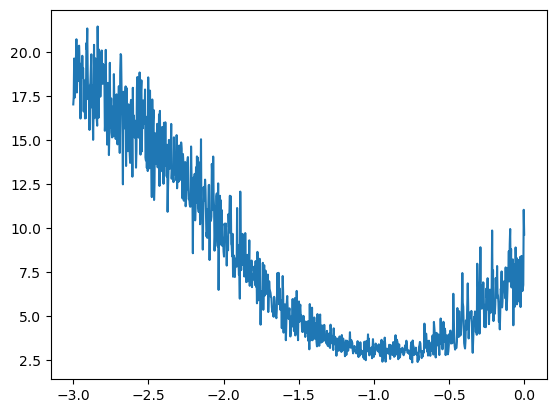

In [21]:
plt.plot(lri, lossi)

In [22]:
# Training
for i in range(10000):
    # Minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.5
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.6621181964874268


In [23]:
# Create the data sets
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Training split (80%)
Xtr, Ytr = build_dataset(words[:n1])

# Dev/validation split (10%)
Xdev, Ydev = build_dataset(words[n1:n2])

# Test split (10%)
Xte, Yte = build_dataset(words[n2:])

In [24]:
# Parameters
C = torch.randn((27, 10))
W1 = torch.randn((30, 200))
b1 = torch.randn(200)
W2 = torch.randn((200, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

lossi = []
stepi = []

In [25]:
W1.shape[1]

200

In [26]:
# Training
for i in range(200000):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    emb = C[Xtr[ix]]  # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 200)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

1.7651793956756592


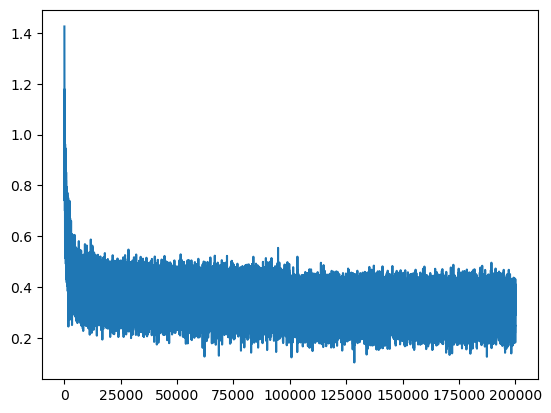

In [27]:
plt.plot(stepi, lossi)

In [28]:
# Evaluate training
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.1139519214630127


In [29]:
# Evaluate dev
emb = C[Xdev]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1565704345703125


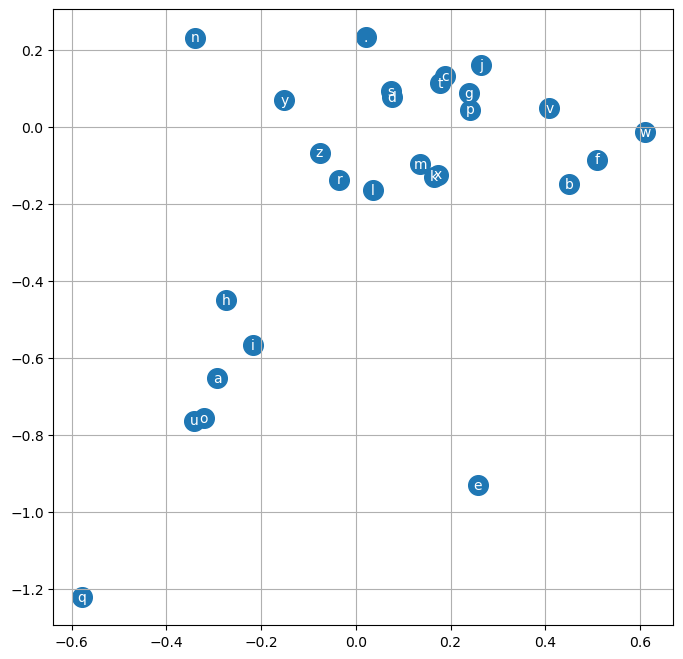

In [30]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")

In [31]:
for _ in range(20):
    out = ""
    context = [0] * 3
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out += itos[ix]

    print(out)

makendreigh
gavannora
jaxxtonna
keizesyn
fran
vadi
rhylie
galen
kristi
try
kahlena
rocka
ros
calyanellaw
zamalenyiq
kylea
eliyah
sha
malwe
karijchabira


## [Exercises](https://youtu.be/TCH_1BHY58I)


In [32]:
train_words, dev_words, test_words = load_words()

### Exercise 1


In [33]:
mlp = MLP([200], block_size=3, embedding_dim=10, weight_scale=0.01)
mlp.train(
    train_words,
    minibatch_size=32,
    epochs=40,
    regularization=0.01,
    learning_rate=0.1,
)

Epoch 0 Loss: 2.5369691848754883
Epoch 1 Loss: 2.8381664752960205
Epoch 2 Loss: 2.5332117080688477
Epoch 3 Loss: 2.224520206451416
Epoch 4 Loss: 2.1530086994171143
Epoch 5 Loss: 2.8715627193450928
Epoch 6 Loss: 2.2779881954193115
Epoch 7 Loss: 1.9116058349609375
Epoch 8 Loss: 1.9115246534347534
Epoch 9 Loss: 2.5593390464782715
Epoch 10 Loss: 2.0334911346435547
Learning rate reduced to 0.01
Epoch 11 Loss: 2.5354671478271484
Epoch 12 Loss: 1.816579818725586
Epoch 13 Loss: 2.0181524753570557
Epoch 14 Loss: 2.2958595752716064
Epoch 15 Loss: 2.1950511932373047
Epoch 16 Loss: 1.9858990907669067
Epoch 17 Loss: 1.9746757745742798
Epoch 18 Loss: 2.089125871658325
Epoch 19 Loss: 2.140197992324829
Epoch 20 Loss: 2.225043773651123
Learning rate reduced to 0.001
Epoch 21 Loss: 2.450284957885742
Epoch 22 Loss: 2.447918653488159
Epoch 23 Loss: 2.0798721313476562
Epoch 24 Loss: 2.0373406410217285
Epoch 25 Loss: 2.228476047515869
Epoch 26 Loss: 1.946348786354065
Epoch 27 Loss: 1.8768529891967773
Epoch 

In [34]:
for _ in range(20):
    print(mlp.forward())

niy
tay
lyx
alareknaella
koemannelissaris
stana
kenzy
dehaaria
zey
jayas
miseya
kelan
nic
zoviaalyn
bastin
ashlee
maria
brabeltanne
penalterlynn
thri


In [35]:
for _ in range(10):
    print(mlp.forward("sam"))

samirack
samarlianna
samfrin
samaldie
samrin
samaylin
samen
samultin
sam
samyad


In [36]:
print(mlp.evaluate(dev_words))
print(mlp.evaluate(test_words))

2.171713352203369
2.1657910346984863
